In [1]:
import cv2
import numpy as np
import cv2
import numpy as np
import time

In [8]:
def avg_circles(circles, b):
    avg_x=0
    avg_y=0
    avg_r=0
    for i in range(b):
        #optional - average for multiple circles (can happen when a gauge is at a slight angle)
        avg_x = avg_x + circles[0][i][0]
        avg_y = avg_y + circles[0][i][1]
        avg_r = avg_r + circles[0][i][2]
    avg_x = int(avg_x/(b))
    avg_y = int(avg_y/(b))
    avg_r = int(avg_r/(b))
    return avg_x, avg_y, avg_r

def dist_2_pts(x1, y1, x2, y2):
    #print np.sqrt((x2-x1)^2+(y2-y1)^2)
	return np.sqrt((x2 - x1)**2 + (y2 - y1)**2)

def calibrate_gauge(filename,folder_path):
	'''
		This function should be run using a test image in order to calibrate the range available to the dial as well as the
        units.  It works by first finding the center point and radius of the gauge.  Then it draws lines at hard coded intervals
        (separation) in degrees.  It then prompts the user to enter position in degrees of the lowest possible value of the gauge,
        as well as the starting value (which is probably zero in most cases but it won't assume that).  It will then ask for the
        position in degrees of the largest possible value of the gauge. Finally, it will ask for the units.  This assumes that
        the gauge is linear (as most probably are).
        It will return the min value with angle in degrees (as a tuple), the max value with angle in degrees (as a tuple),
        and the units (as a string).
	'''

	img = cv2.imread(folder_path + "/" + filename + ".jpg")
	height, width = img.shape[:2]
	gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  #convert to gray
    #gray = cv2.GaussianBlur(gray, (5, 5), 0)
    # gray = cv2.medianBlur(gray, 5)

    #for testing, output gray image
    #cv2.imwrite('gauge-%s-bw.%s' %(gauge_number, file_type),gray)

    #detect circles
    #restricting the search from 35-48% of the possible radii gives fairly good results across different samples.  Remember that
    #these are pixel values which correspond to the possible radii search range.
	circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, 1, 20, np.array([]), 100, 50, int(height*0.35), int(height*0.48))
    # average found circles, found it to be more accurate than trying to tune HoughCircles parameters to get just the right one
	a, b, c = circles.shape
	x,y,r = avg_circles(circles, b)

    #draw center and circle
	cv2.circle(img, (x, y), r, (0, 0, 255), 3, cv2.LINE_AA)  # draw circle
	cv2.circle(img, (x, y), 2, (0, 255, 0), 3, cv2.LINE_AA)  # draw center of circle

    #for calibration, plot lines from center going out at every 10 degrees and add marker
    #for i from 0 to 36 (every 10 deg)

	'''
    goes through the motion of a circle and sets x and y values based on the set separation spacing.  Also adds text to each
    line.  These lines and text labels serve as the reference point for the user to enter
    NOTE: by default this approach sets 0/360 to be the +x axis (if the image has a cartesian grid in the middle), the addition
    (i+9) in the text offset rotates the labels by 90 degrees so 0/360 is at the bottom (-y in cartesian).  So this assumes the
    gauge is aligned in the image, but it can be adjusted by changing the value of 9 to something else.
	'''
	separation = 10.0 #in degrees
	interval = int(360 / separation)
	p1 = np.zeros((interval,2))  #set empty arrays
	p2 = np.zeros((interval,2))
	p_text = np.zeros((interval,2))
	for i in range(0,interval):
		for j in range(0,2):
			if (j%2==0):
				p1[i][j] = x + 0.9 * r * np.cos(separation * i * 3.14 / 180) #point for lines
			else:
				p1[i][j] = y + 0.9 * r * np.sin(separation * i * 3.14 / 180)
	text_offset_x = 10
	text_offset_y = 5
	for i in range(0, interval):
		for j in range(0, 2):
			if (j % 2 == 0):
				p2[i][j] = x + r * np.cos(separation * i * 3.14 / 180)
				p_text[i][j] = x - text_offset_x + 1.2 * r * np.cos((separation) * (i+9) * 3.14 / 180) #point for text labels, i+9 rotates the labels by 90 degrees
			else:
				p2[i][j] = y + r * np.sin(separation * i * 3.14 / 180)
				p_text[i][j] = y + text_offset_y + 1.2* r * np.sin((separation) * (i+9) * 3.14 / 180)  # point for text labels, i+9 rotates the labels by 90 degrees

    #add the lines and labels to the image
	for i in range(0,interval):
		cv2.line(img, (int(p1[i][0]), int(p1[i][1])), (int(p2[i][0]), int(p2[i][1])),(0, 255, 0), 2)
		cv2.putText(img, '%s' %(int(i*separation)), (int(p_text[i][0]), int(p_text[i][1])), cv2.FONT_HERSHEY_SIMPLEX, 0.3,(0,0,0),1,cv2.LINE_AA)

    #for testing, you can comment below
	cv2.imwrite(folder_path + "/" + filename + "-calibration.jpg", img)

    #get user input on min, max, values, and units
	print ("For image file:" + filename + "-calibration.jpg")
	min_angle = input('Min angle (lowest possible angle of dial) - in degrees: ') #the lowest possible angle
	max_angle = input('Max angle (highest possible angle) - in degrees: ') #highest possible angle
	min_value = input('Min value: ') #usually zero
	max_value = input('Max value: ') #maximum reading of the gauge
	units = input('Enter units: ')

    #for testing purposes: hardcode and comment out raw_inputs above
    # min_angle = 45
    # max_angle = 320
    # min_value = 0
    # max_value = 200
    # units = "PSI"

	return min_angle, max_angle, min_value, max_value, units, x, y, r

def get_current_value(img, min_angle, max_angle, min_value, max_value, x, y, r, filename,folder_path):

    #for testing purposes
    #img = cv2.imread('gauge-%s.%s' % (gauge_number, file_type))

	gray2 = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

	# Set threshold and maxValue
	thresh = 175
	maxValue = 255

    # for testing purposes, found cv2.THRESH_BINARY_INV to perform the best
    # th, dst1 = cv2.threshold(gray2, thresh, maxValue, cv2.THRESH_BINARY);
    # th, dst2 = cv2.threshold(gray2, thresh, maxValue, cv2.THRESH_BINARY_INV);
    # th, dst3 = cv2.threshold(gray2, thresh, maxValue, cv2.THRESH_TRUNC);
    # th, dst4 = cv2.threshold(gray2, thresh, maxValue, cv2.THRESH_TOZERO);
    # th, dst5 = cv2.threshold(gray2, thresh, maxValue, cv2.THRESH_TOZERO_INV);
    # cv2.imwrite('gauge-%s-dst1.%s' % (gauge_number, file_type), dst1)
    # cv2.imwrite('gauge-%s-dst2.%s' % (gauge_number, file_type), dst2)
    # cv2.imwrite('gauge-%s-dst3.%s' % (gauge_number, file_type), dst3)
    # cv2.imwrite('gauge-%s-dst4.%s' % (gauge_number, file_type), dst4)
    # cv2.imwrite('gauge-%s-dst5.%s' % (gauge_number, file_type), dst5)

    # apply thresholding which helps for finding lines
	th, dst2 = cv2.threshold(gray2, thresh, maxValue, cv2.THRESH_BINARY_INV);

    # found Hough Lines generally performs better without Canny / blurring, though there were a couple exceptions where it would only work with Canny / blurring
    #dst2 = cv2.medianBlur(dst2, 5)
    #dst2 = cv2.Canny(dst2, 50, 150)
    #dst2 = cv2.GaussianBlur(dst2, (5, 5), 0)

    # for testing, show image after thresholding
    #cv2.imwrite('gauge-%s-tempdst2.%s' % (gauge_number, file_type), dst2)

    # find lines
	minLineLength = 10
	maxLineGap = 0
	lines = cv2.HoughLinesP(image=dst2, rho=3, theta=np.pi / 180, threshold=100,minLineLength=minLineLength, maxLineGap=0)  # rho is set to 3 to detect more lines, easier to get more then filter them out later

    #for testing purposes, show all found lines
    # for i in range(0, len(lines)):
    #   for x1, y1, x2, y2 in lines[i]:
    #      cv2.line(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
    #      cv2.imwrite('gauge-%s-lines-test.%s' %(gauge_number, file_type), img)

    # remove all lines outside a given radius
	final_line_list = []
    #print "radius: %s" %r

	diff1LowerBound = 0.15 #diff1LowerBound and diff1UpperBound determine how close the line should be from the center
	diff1UpperBound = 0.25
	diff2LowerBound = 0.5 #diff2LowerBound and diff2UpperBound determine how close the other point of the line should be to the outside of the gauge
	diff2UpperBound = 1.0
	for i in range(0, len(lines)):
		for x1, y1, x2, y2 in lines[i]:
			diff1 = dist_2_pts(x, y, x1, y1)  # x, y is center of circle
			diff2 = dist_2_pts(x, y, x2, y2)  # x, y is center of circle
			#set diff1 to be the smaller (closest to the center) of the two), makes the math easier
			if (diff1 > diff2):
				temp = diff1
				diff1 = diff2
				diff2 = temp
            # check if line is within an acceptable range
			if (((diff1<diff1UpperBound*r) and (diff1>diff1LowerBound*r) and (diff2<diff2UpperBound*r)) and (diff2>diff2LowerBound*r)):
				line_length = dist_2_pts(x1, y1, x2, y2)
				# add to final list
				final_line_list.append([x1, y1, x2, y2])

    #testing only, show all lines after filtering
    # for i in range(0,len(final_line_list)):
    #     x1 = final_line_list[i][0]
    #     y1 = final_line_list[i][1]
    #     x2 = final_line_list[i][2]
    #     y2 = final_line_list[i][3]
    #     cv2.line(img, (x1, y1), (x2, y2), (0, 255, 0), 2)

    # assumes the first line is the best one
	x1 = final_line_list[0][0]
	y1 = final_line_list[0][1]
	x2 = final_line_list[0][2]
	y2 = final_line_list[0][3]
	cv2.line(img, (x1, y1), (x2, y2), (0, 255, 0), 2)

    #for testing purposes, show the line overlayed on the original image
	cv2.imwrite(folder_path + "/" + filename + "-needle.jpg", img)

    #find the farthest point from the center to be what is used to determine the angle
	dist_pt_0 = dist_2_pts(x, y, x1, y1)
	dist_pt_1 = dist_2_pts(x, y, x2, y2)
	if (dist_pt_0 > dist_pt_1):
		x_angle = x1 - x
		y_angle = y - y1
	else:
		x_angle = x2 - x
		y_angle = y - y2
    # take the arc tan of y/x to find the angle
	res = np.arctan(np.divide(float(y_angle), float(x_angle)))
    #np.rad2deg(res) #coverts to degrees

    # print x_angle
    # print y_angle
    # print res
    # print np.rad2deg(res)

    #these were determined by trial and error
	res = np.rad2deg(res)
	if x_angle > 0 and y_angle > 0:  #in quadrant I
		final_angle = 270 - res
	if x_angle < 0 and y_angle > 0:  #in quadrant II
		final_angle = 90 - res
	if x_angle < 0 and y_angle < 0:  #in quadrant III
		final_angle = 90 - res
	if x_angle > 0 and y_angle < 0:  #in quadrant IV
		final_angle = 270 - res

    #print final_angle

	old_min = float(min_angle)
	old_max = float(max_angle)

	new_min = float(min_value)
	new_max = float(max_value)

	old_value = final_angle

	old_range = (old_max - old_min)
	new_range = (new_max - new_min)
	new_value = (((old_value - old_min) * new_range) / old_range) + new_min

	return new_value

def main():	
	folder_path = input("Folder name inside this file's folder: ")
	filename = input("Filename without extension .jpg: ")

	min_angle, max_angle, min_value, max_value, units, x, y, r = calibrate_gauge(filename,folder_path)

    #feed an image (or frame) to get the current value, based on the calibration, by default uses same image as calibration
	img = cv2.imread(folder_path + "/" + filename + ".jpg")
	val = get_current_value(img, min_angle, max_angle, min_value, max_value, x, y, r, filename,folder_path)
	print ("Current reading: %s %s" %(("%.2f" % val), units))

if __name__=='__main__':
    main()

KeyboardInterrupt: Interrupted by user

In [11]:
def avg_circles(circles, b):
    avg_x=0
    avg_y=0
    avg_r=0
    for i in range(b):
        #optional - average for multiple circles (can happen when a gauge is at a slight angle)
        avg_x = avg_x + circles[0][i][0]
        avg_y = avg_y + circles[0][i][1]
        avg_r = avg_r + circles[0][i][2]
    avg_x = int(avg_x/(b))
    avg_y = int(avg_y/(b))
    avg_r = int(avg_r/(b))
    return avg_x, avg_y, avg_r

In [ ]:

def dist_2_pts(x1, y1, x2, y2):
    #print np.sqrt((x2-x1)^2+(y2-y1)^2)
    return np.sqrt((x2 - x1)**2 + (y2 - y1)**2)

In [ ]:
def calibrate_gauge(filename,folder_path):

	img = cv2.imread(folder_path + "/" + filename + ".jpg")
	height, width = img.shape[:2]
	gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  #convert to gray
    
	circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, 1, 20, np.array([]), 100, 50, int(height*0.35), int(height*0.48))
	a, b, c = circles.shape
	x,y,r = avg_circles(circles, b)

	cv2.circle(img, (x, y), r, (0, 0, 255), 3, cv2.LINE_AA)  
	cv2.circle(img, (x, y), 2, (0, 255, 0), 3, cv2.LINE_AA)  

	separation = 10.0 #in degrees
	interval = int(360 / separation)
	p1 = np.zeros((interval,2))  #set empty arrays
	p2 = np.zeros((interval,2))
	p_text = np.zeros((interval,2))
	for i in range(0,interval):
		for j in range(0,2):
			if (j%2==0):
				p1[i][j] = x + 0.9 * r * np.cos(separation * i * 3.14 / 180) #point for lines
			else:
				p1[i][j] = y + 0.9 * r * np.sin(separation * i * 3.14 / 180)
	text_offset_x = 10
	text_offset_y = 5
	for i in range(0, interval):
		for j in range(0, 2):
			if (j % 2 == 0):
				p2[i][j] = x + r * np.cos(separation * i * 3.14 / 180)
				p_text[i][j] = x - text_offset_x + 1.2 * r * np.cos((separation) * (i+9) * 3.14 / 180) #point for text labels, i+9 rotates the labels by 90 degrees
			else:
				p2[i][j] = y + r * np.sin(separation * i * 3.14 / 180)
				p_text[i][j] = y + text_offset_y + 1.2* r * np.sin((separation) * (i+9) * 3.14 / 180)  # point for text labels, i+9 rotates the labels by 90 degrees

    #add the lines and labels to the image
	for i in range(0,interval):
		cv2.line(img, (int(p1[i][0]), int(p1[i][1])), (int(p2[i][0]), int(p2[i][1])),(0, 255, 0), 2)
		cv2.putText(img, '%s' %(int(i*separation)), (int(p_text[i][0]), int(p_text[i][1])), cv2.FONT_HERSHEY_SIMPLEX, 0.3,(0,0,0),1,cv2.LINE_AA)

    #for testing, you can comment below
	cv2.imwrite(folder_path + "/" + filename + "-calibration.jpg", img)

    #get user input on min, max, values, and units
	print ("For image file:" + filename + "-calibration.jpg")
	min_angle = input('Min angle (lowest possible angle of dial) - in degrees: ') #the lowest possible angle
	max_angle = input('Max angle (highest possible angle) - in degrees: ') #highest possible angle
	min_value = input('Min value: ') #usually zero
	max_value = input('Max value: ') #maximum reading of the gauge
	units = input('Enter units: ')

	return min_angle, max_angle, min_value, max_value, units, x, y, r

In [24]:
file_name ='frame380 - Copy'
folder_name = 'test'

In [27]:
image = cv2.imread(r"C:\Users\Admin\Desktop\OCR project\test\frame380.jpg")

In [32]:
height,width = image.shape[:2]
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

In [36]:
cv2.imwrite(r"C:\Users\Admin\Desktop\OCR project\test\frame380_gray.jpg",gray)

True

In [33]:
from matplotlib import pyplot as plt 

In [38]:
im_data = plt.imread(r"C:\Users\Admin\Desktop\OCR project\test\frame380_gray.jpg")
height,width,depth = im_data.shape

ValueError: not enough values to unpack (expected 3, got 2)

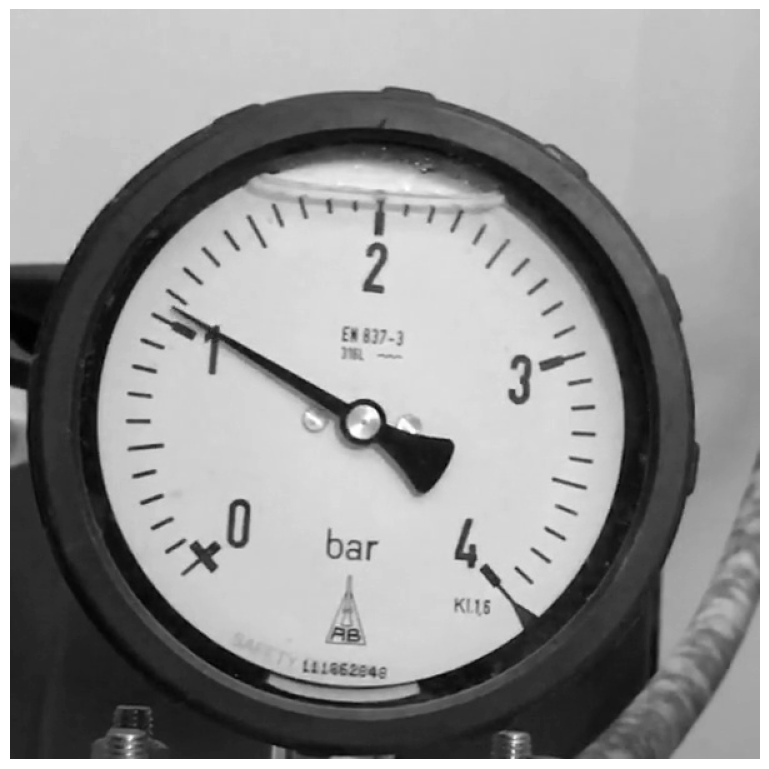

In [42]:
dpi = 80
heigth,width = im_data.shape
fig_size = width /float(dpi),heigth/float(dpi)
fig = plt.figure(figsize= fig_size)
ax = fig.add_axes([0,0,1,1])
ax.axis('off')
ax.imshow(im_data,cmap ='gray')
plt.show()
    

In [44]:
circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, 1, 20, np.array([]), 100, 50, int(height*0.35), int(height*0.48))
circles   

array([[[282.5, 331.5, 237.1],
        [265.5, 318.5, 248.7],
        [299.5, 309.5, 238.2],
        [253.5, 343.5, 239. ],
        [303.5, 329.5, 248.8],
        [288.5, 356.5, 211.5],
        [276.5, 300.5, 240.9],
        [265.5, 361.5, 237.9],
        [310.5, 290.5, 217. ],
        [283.5, 275.5, 212.6]]], dtype=float32)

In [53]:
circles[0][1][0]
x,y,r = int(circles[0][0][0]),int(circles[0][1][0]),int(circles[0][2][0])

In [30]:
import cv2
import numpy as np
import sys
cap = cv2.VideoCapture(0)
while(True):
    gray = cv2.medianBlur(cv2.cvtColor(cap.read()[1], cv2.COLOR_BGR2GRAY),5)
    cirles=cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, 1, 10)# ret=[[Xpos,Ypos,Radius],...]
    if cirles!=None:print "Circle There !"
    cv2.imshow('video',gray)
    if cv2.waitKey(1)==27:# esc Key
        break
cap.release()
cv2.destroyAllWindows()


600

In [48]:
282.5, 331.5, 237.1

In [56]:
cv2.circle(image, (x, y), r, (0, 0, 255), 3, cv2.LINE_AA)  
cv2.imshow('test',image)
cv2.waitKey(0)

-1

In [7]:
import pygame
import sys
import math

# Initialize pygame
pygame.init()

# Load your image
image_path = r"C:\Users\Admin\Desktop\OCR project\frame342.jpg"
image = pygame.image.load(image_path)
image_width, image_height = image.get_size()

# Set up colors
BLACK = (0, 0, 0)
WHITE = (255, 255, 255)

# Set up variables for circle and square
circle_center = (0, 0)
radius = 0

# Create a copy of the original image to draw on
modified_image = image.copy()

# Set up the screen
screen_width = image_width
screen_height = image_height
screen = pygame.display.set_mode((screen_width, screen_height))
pygame.display.set_caption("Draw on Image")

# Main loop
running = True
while running:
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            running = False
        elif event.type == pygame.MOUSEBUTTONDOWN:
            # Get the position of the mouse click
            circle_center = event.pos
        elif event.type == pygame.MOUSEMOTION and event.buttons[0] == 1:
            # Adjust the radius based on the mouse motion while left mouse button is held down
            x_diff = event.pos[0] - circle_center[0]
            y_diff = event.pos[1] - circle_center[1]
            radius = int(math.sqrt(x_diff ** 2 + y_diff ** 2))

            # Clear the modified image
            modified_image = image.copy()

            # Draw the square
            square_side = radius * 2
            square_rect = pygame.Rect(circle_center[0] - radius, circle_center[1] - radius, square_side, square_side)
            pygame.draw.rect(modified_image, BLACK, square_rect, 2)

            # Draw the circle
            pygame.draw.circle(modified_image, BLACK, circle_center, radius, 2)

            # Draw the line through the center of the circle
            start_point = (circle_center[0] - radius, circle_center[1])
            end_point = (circle_center[0] + radius, circle_center[1])
            start_point_1 = (circle_center[0], circle_center[1] - radius)
            end_point_1 = (circle_center[0], circle_center[1] + radius)
            pygame.draw.line(modified_image, BLACK, start_point, end_point, 2)
            pygame.draw.line(modified_image, BLACK, start_point_1, end_point_1, 2)

            # Blit the modified image onto the screen
            screen.blit(modified_image, (0, 0))

            # Update the display
            pygame.display.flip()

# Save the modified image to a file
pygame.image.save(modified_image, 'modified_image.png')

# Quit pygame
pygame.quit()
sys.exit()


pygame 2.5.2 (SDL 2.28.3, Python 3.9.13)
Hello from the pygame community. https://www.pygame.org/contribute.html


SystemExit: 

C:\Users\Admin\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3465: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [2]:
from ultralytics import YOLO
model = YOLO('best.pt')

In [6]:
results = model(r"C:\Users\Admin\Desktop\MainCode\images\frame190.jpg",save = True)


image 1/1 C:\Users\Admin\Desktop\MainCode\images\frame190.jpg: 640x640 1 pointertip, 1 Scalemium, 1 Scalemaximum, 1 PointerCenter, 192.2ms
Speed: 8.5ms preprocess, 192.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)
Results saved to C:\Users\Admin\runs\detect\predict3


In [75]:
def calculate_center_from_xywh(x, y, w, h):
    center_x = x + w / 2
    center_y = y + h / 2
    return center_x, center_y

import math

def calculate_distance(x1, y1, x2, y2):
    distance = math.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    return distance

def calculate_angle(x1, y1, x2, y2, x3, y3):
    # Calculate vectors between the points
    vector1 = (x1 - x2, y1 - y2)
    vector2 = (x3 - x2, y3 - y2)

    # Calculate dot product
    dot_product = vector1[0] * vector2[0] + vector1[1] * vector2[1]

    # Calculate magnitudes of the vectors
    magnitude1 = math.sqrt(vector1[0] ** 2 + vector1[1] ** 2)
    magnitude2 = math.sqrt(vector2[0] ** 2 + vector2[1] ** 2)

    # Calculate cosine of the angle
    cosine_angle = dot_product / (magnitude1 * magnitude2)

    # Calculate the angle in radians
    angle_radians = math.acos(cosine_angle)

    # Convert radians to degrees
    angle_degrees = math.degrees(angle_radians)

    return angle_degrees


In [80]:
def calculate_mapped_value(boxes):
    x_pointer, y_pointer = None, None
    x_smin, y_smin = None, None
    x_smax, y_smax = None, None
    x_pointer_center, y_pointer_center = None, None
    angle = 0

    for box in boxes:
        if box.cls == 0:
            x_pointer, y_pointer = calculate_center_from_xywh(float(box.xywhn[0][0]), float(box.xywhn[0][1]), float(box.xywhn[0][2]), float(box.xywhn[0][3]))
        elif box.cls == 1:
            x_smin, y_smin = calculate_center_from_xywh(float(box.xywhn[0][0]), float(box.xywhn[0][1]), float(box.xywhn[0][2]), float(box.xywhn[0][3]))
        elif box.cls == 2:
            x_smax, y_smax = calculate_center_from_xywh(float(box.xywhn[0][0]), float(box.xywhn[0][1]), float(box.xywhn[0][2]), float(box.xywhn[0][3]))
        elif box.cls == 3:
            x_pointer_center, y_pointer_center = calculate_center_from_xywh(float(box.xywhn[0][0]), float(box.xywhn[0][1]), float(box.xywhn[0][2]), float(box.xywhn[0][3]))

    if x_pointer is not None and x_pointer_center is not None and x_smin is not None and y_smin is not None:
        if x_pointer <= x_pointer_center:
            angle = calculate_angle(x_pointer, y_pointer, x_pointer_center, y_pointer_center, x_smin, y_smin)
        elif x_pointer > x_pointer_center:
            angle = 270 - calculate_angle(x_pointer, y_pointer, x_pointer_center, y_pointer_center, x_smax, y_smax)

    # Now we map the angle to a value within the specified range
    max_value = 4
    min_value = 0
    value_range = max_value - min_value
    mapped_value = (value_range / 270) * angle

    return mapped_value

0.6319685244423012

In [76]:
calculate_angle(x_pointer,y_pointer,x_pointer_center,y_pointer_center,x_smin,y_smin)

42.65787539985533

In [53]:
boxes[0].xywhn

tensor([[0.4710, 0.5511, 0.0579, 0.0620]])

In [35]:
x_pointer,y_pointer

(111, 319)

In [43]:
x_pointer_center,y_pointer_center

(0, 0)

In [33]:
boxes[0].xyxy[0]

tensor([265.2152, 312.0489, 299.9718, 349.2345])

In [9]:
import cv2
import numpy as np

# Load the image of the analog gauge
image = cv2.imread(r"C:\Users\Admin\Desktop\MainCode\images\frame190.jpg")

# Convert the image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply Gaussian blur to reduce noise
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

# Thresholding
_, threshold = cv2.threshold(blurred, 100, 255, cv2.THRESH_BINARY)

# Find contours
contours, _ = cv2.findContours(threshold.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Sort contours by area and find the largest contour
contours = sorted(contours, key=cv2.contourArea, reverse=True)[:1]

for contour in contours:
    # Calculate the centroid of the contour
    M = cv2.moments(contour)
    cx = int(M['m10'] / M['m00'])
    cy = int(M['m01'] / M['m00'])
    
    # Draw a circle at the centroid (for visualization)
    cv2.circle(image, (cx, cy), 5, (0, 0, 255), -1)

# Display the result
cv2.imshow('Analog Gauge', image)
cv2.waitKey(0)
cv2.destroyAllWindows()
